In [1]:
import pandas as pd
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt
sns.set()

pd.set_option('display.max_columns', 500)

In [2]:
def get_best_results(metrics):
    model_params = [col for col in metrics.columns if 'model_params' in col or 'selection_params' in col ]

    groupby_cols = ['dataset', 'selection_name', 'model_name', *model_params]
    grouped = metrics.groupby(groupby_cols, dropna=False)[["rmse_valid"]].mean()

    total_metrics_indexed = metrics.set_index(groupby_cols)

    best_results = total_metrics_indexed.loc[grouped.groupby(['dataset', 'selection_name', 'model_name'], dropna=False).rmse_valid.idxmin(), ['rmse', 'mae', 'mse', 'mape', 'dataset_params_test_year', 'dataset_params_seq_len', 'dataset_params_crossval', "dataset_params_shift","dataset_params_pred_len",  'selected_features', 'duration', 'n_features']].reset_index()

    return best_results

def count_features(feats):

    result = 0
    if type(feats) == list:
        result = len(feats)
    else:
        values = []
        for _,v in feats.items():
            values.extend(list(v))
        result = len(set(values))

    return result


In [3]:
total_metrics = pd.read_csv("results/ResSelNet/results_pollution_expanding_window.csv")

total_metrics["n_features"] = total_metrics.selected_features.apply(eval).apply(count_features)

In [4]:
total_metrics['model_name'] = total_metrics['model_name'].replace({'decisiontree': 'DT', 'lstm': "LSTM"})
total_metrics['selection_name'] = total_metrics['selection_name'].replace({'NoSelection': 'NS', 'TimeSelectionLayer': 'TSL', 'TimeSelectionLayerResidual': 'TSL'})

total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='LSTM')  & (total_metrics.selection_params_residual), 'model_name'] = 'LSTM*'
total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='LSTM')& (~total_metrics.selection_params_residual.fillna(False)), 'model_name'] = 'TLSTM'
total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='dense')& (total_metrics.selection_params_residual), 'model_name'] = 'FF*'
total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='dense')& (~total_metrics.selection_params_residual.fillna(False)), 'model_name'] = 'TFF'

total_metrics['model_name'] = total_metrics['model_name'].replace({'dense': 'FF', 'lasso': 'L1'})
total_metrics['dataset'] = total_metrics['dataset_name'].apply(lambda x: x.capitalize()).replace({'Rondadelvalle': 'Ronda del valle'})

In [5]:
best_results = get_best_results(total_metrics)
best_results.groupby(['dataset', 'model_name'], dropna=False)[['rmse', "mse", "mae", "duration", 'n_features', 'dataset_params_seq_len']].mean().reset_index().pivot(index = 'model_name', columns='dataset', values=['mae', 'mse', 'rmse']).round(1)#.to_latex('tables/efficacy.tex')

mae                                                  \
dataset    Aljarafe0523 Asomadilla0523 Bermejales0523 Rondadelvalle0523   
model_name                                                                
DT                 12.6           12.3           13.9              14.1   
FF                 12.2           12.0           14.2              14.0   
FF*                11.7           11.1           13.3              13.2   
L1                 11.8           11.4           13.1              13.2   
LSTM               12.0           11.5           13.3              13.4   
LSTM*              11.6           11.2           13.0              13.1   
TFF                11.8           11.3           13.2              13.6   
TLSTM              11.9           11.4           13.5              13.2   

                               mse                                \
dataset    Torneo0523 Aljarafe0523 Asomadilla0523 Bermejales0523   
model_name                                                         
DT               12.1        260.3          247.8          316.4   
FF               11.8        244.5          233.8          323.1   
FF*              11.1        228.8          214.1          299.2   
L1               11.5        229.6          218.4          282.6   
LSTM             11.6        237.6          220.1          288.9   
LSTM*            11.2        225.9          213.4          279.8   
TFF              11.4        229.1          215.5          288.7   
TLSTM            11.7        232.2          219.4          292.9   

                                                rmse                 \
dataset    Rondadelvalle0523 Torneo0523 Aljarafe0523 Asomadilla0523   
model_name                                                            
DT                     335.0      241.1         16.1           15.7   
FF                     321.7      228.1         15.6           15.3   
FF*                    297.4      207.7         15.1           14.6   
L1                     291.3      210.8         15.1           14.8   
LSTM                   304.4      222.0         15.4           14.8   
LSTM*                  299.7      208.6         15.0           14.6   
TFF                    304.4      212.0         15.1           14.7   
TLSTM                  295.8      222.8         15.2           14.8   

                                                        
dataset    Bermejales0523 Rondadelvalle0523 Torneo0523  
model_name                                              
DT                   17.8              18.3       15.5  
FF                   18.0              17.9       15.1  
FF*                  17.2              17.2       14.4  
L1                   16.8              17.0       14.5  
LSTM                 17.0              17.4       14.9  
LSTM*                16.7              17.3       14.4  
TFF                  17.0              17.4       14.6  
TLSTM                17.1              17.2       14.9

In [6]:
best_results.groupby(['dataset', 'model_name', 'dataset_params_test_year'], dropna=False)[["rmse", "mse", "mae", "duration", 'n_features']].mean().reset_index().query("model_name == 'L1' or model_name == 'TLSTMRes' or model_name == 'TFFRes'").pivot(index = ['dataset_params_test_year'], columns=["dataset", 'model_name'], values=['rmse']).dropna().round(1)#.to_latex('tables/efficacy_by_year.tex')

rmse                                \
dataset                  Aljarafe0523 Asomadilla0523 Bermejales0523   
model_name                         L1             L1             L1   
dataset_params_test_year                                              
2013                             15.4           14.9           17.8   
2014                             15.3           15.8           17.6   
2015                             16.5           15.5           17.0   
2016                             15.2           15.0           16.8   
2017                             15.4           15.6           17.4   
2018                             14.6           14.9           17.7   
2019                             14.6           15.1           17.6   
2020                             13.7           13.8           16.3   
2021                             13.5           14.7           16.5   
2022                             14.0           13.2           14.9   
2023                             16.0           13.8           13.5   

                                                       
dataset                  Rondadelvalle0523 Torneo0523  
model_name                              L1         L1  
dataset_params_test_year                               
2013                                  17.0       14.2  
2014                                  17.9       14.1  
2015                                  17.5       14.2  
2016                                  17.8       13.9  
2017                                  19.4       14.7  
2018                                  18.0       14.6  
2019                                  17.0       14.9  
2020                                  15.2       14.3  
2021                                  16.6       14.7  
2022                                  16.1       14.9  
2023                                  16.1       14.6

In [7]:
total_metrics.columns

Index(['mae', 'mse', 'rmse', 'r2', 'mape', 'mae_valid', 'mse_valid',
       'rmse_valid', 'r2_valid', 'mape_valid', 'dataset_name',
       'dataset_params_seq_len', 'dataset_params_pred_len',
       'dataset_params_shift', 'dataset_params_crossval',
       'dataset_params_test_year', 'selection_name', 'selection_params',
       'model_name', 'model_params_layers', 'model_params_units',
       'model_params_dropout', 'model_params_batch_size', 'model_params_lr',
       'model_params_type', 'code', 'selected_features', 'duration', 'history',
       'val_loss', 'model_params_max_depth', 'model_params_alpha',
       'selection_params_regularization', 'selection_params_residual',
       'n_features', 'dataset'],
      dtype='object')

<Figure size 1440x1440 with 0 Axes>

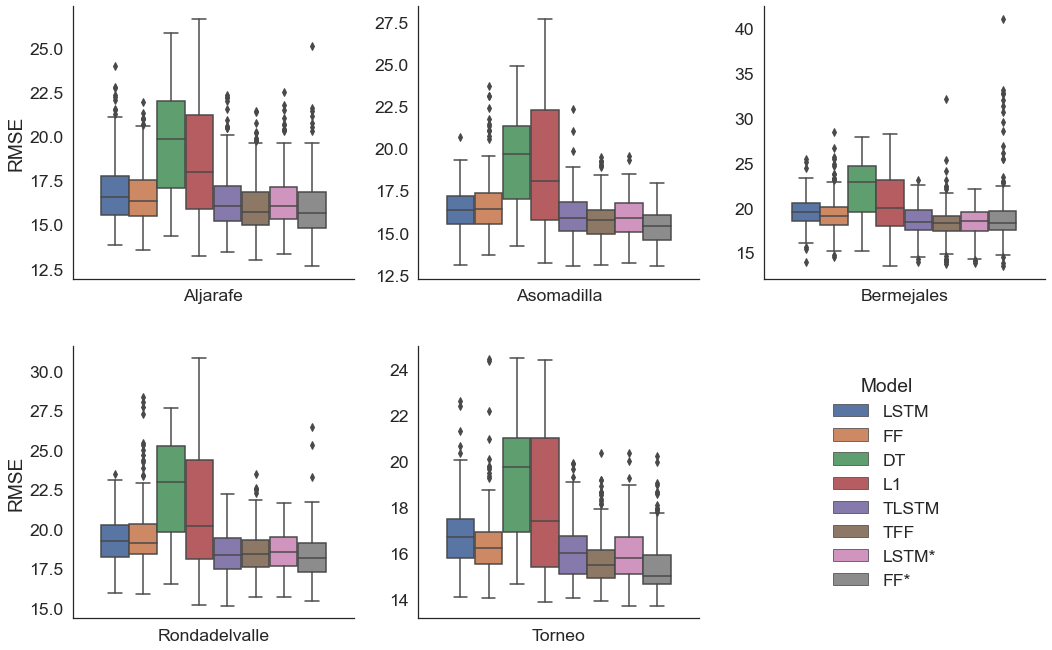

In [51]:
sns.set(font_scale=1.6, style='white')
plt.figure(figsize=(20,20))
#total_metrics.loc[:, 'selection_params_residual'] = total_metrics.loc[:, 'selection_params_residual'].fillna(False)
total_metrics_renamed = total_metrics.rename({'model_name': 'Model', 'rmse': 'RMSE', 'n_features': '# Features', 'duration': 'Duration'}, axis=1)
total_metrics_renamed["dataset"] = total_metrics_renamed["dataset"].str[:-4]
g = sns.catplot(data=total_metrics_renamed, kind='box', x='dataset', y="RMSE", col='dataset', hue='Model', sharex=False, sharey=False, col_wrap=3, legend=True)
g.set(xlabel=None)
g.set_titles(template='')

sns.move_legend(g, "upper left", bbox_to_anchor=(.70, .45))

plt.savefig('figures/boxplot_RMSE.png')

plt.show()

<Figure size 1440x1440 with 0 Axes>

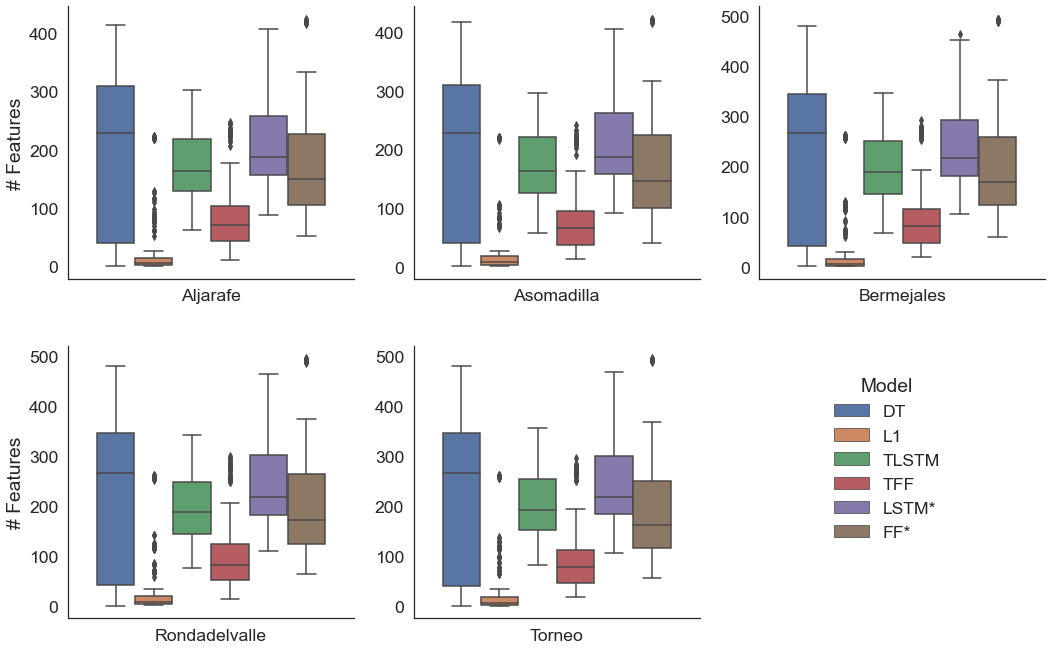

In [50]:
sns.set(font_scale=1.6, style='white')
plt.figure(figsize=(20,20))

g = sns.catplot(data=total_metrics_renamed[(total_metrics_renamed.Model != 'LSTM') & (total_metrics_renamed.Model != 'FF')], kind='box', x='dataset', y="# Features", col='dataset', hue='Model', sharex=False, sharey=False, col_wrap=3, legend=True)#.set_yscale("log")
g.set(xlabel=None)
g.set_titles(template='')
sns.move_legend(g, "upper left", bbox_to_anchor=(.70, .45))

plt.savefig('figures/boxplot_Features.png')
plt.show()
plt.show()

## Selection masks

In [10]:
from itertools import product
import numpy as np

def get_mask_df(selection_masks, features_list, maximum_seq_len, dataset, levels):
    mask_dict = {}
    lags = np.array([f't-{t}'for t in range (maximum_seq_len, 0, -1)])

    mask_dict["layer_level"] = selection_masks.flatten().tolist()

    feats_lags = list(product(features_list, lags))

    mask_dict["features"] = [fl[0] for fl in feats_lags]
    mask_dict["lags"] = [fl[1] for fl in feats_lags]

    df_mask = pd.DataFrame(mask_dict)

    df_mask["dataset"] = dataset

    df_mask["layer"] = df_mask["layer_level"].map(lambda l: levels[int(l)])

    return df_mask

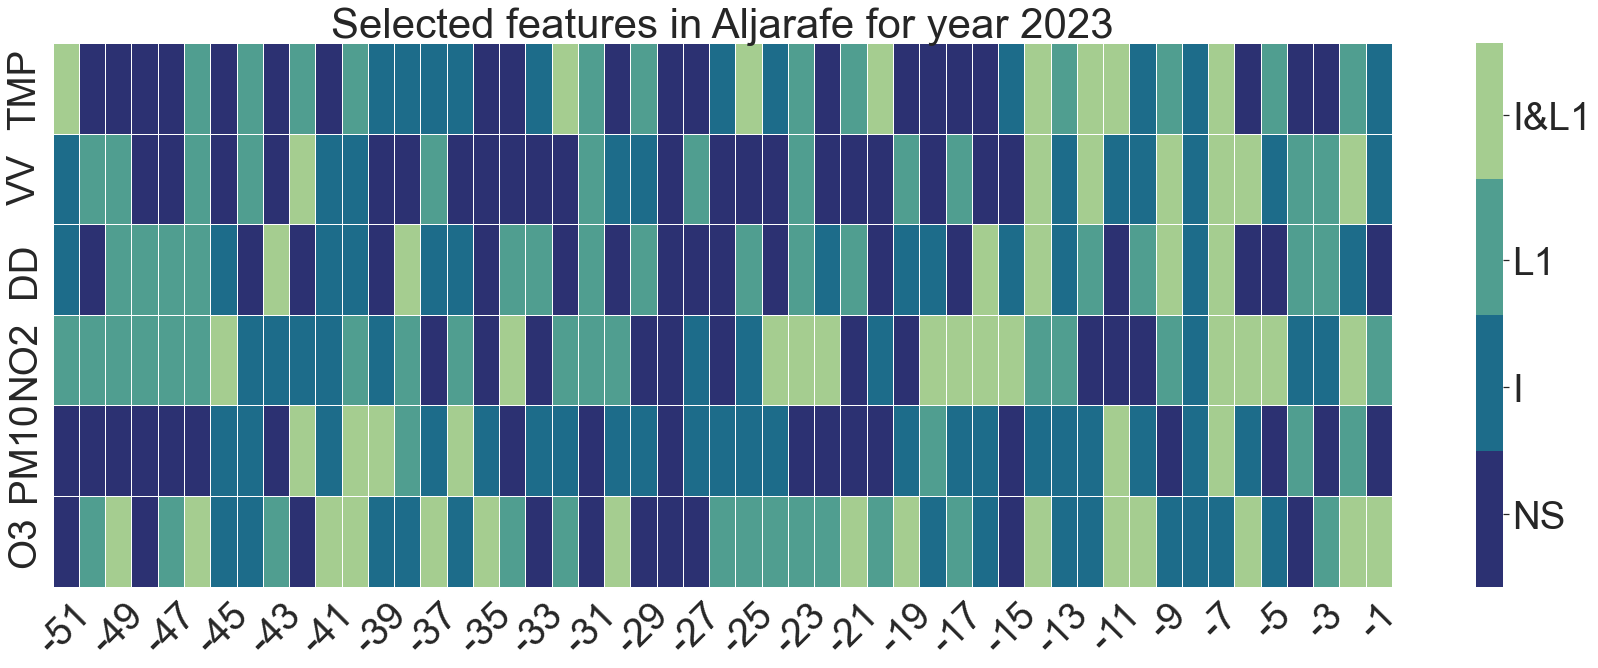

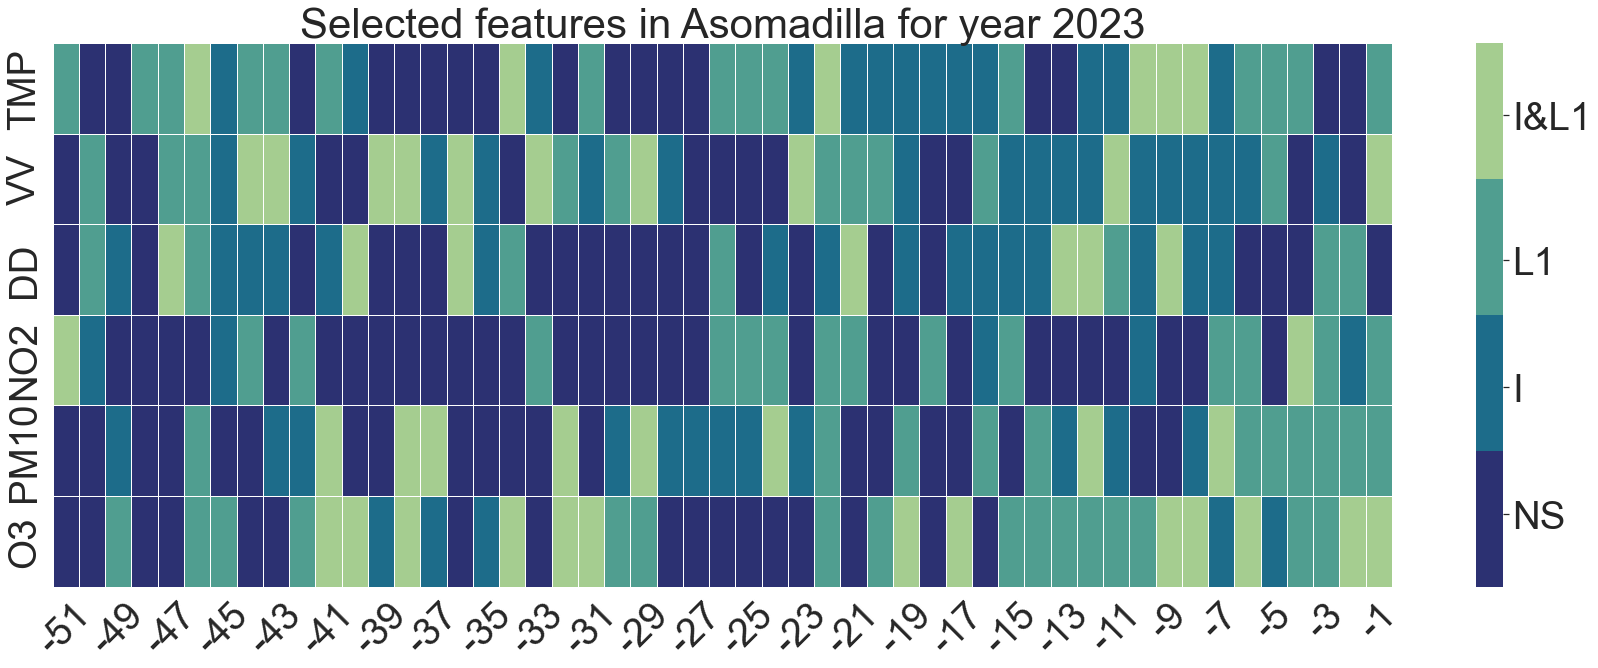

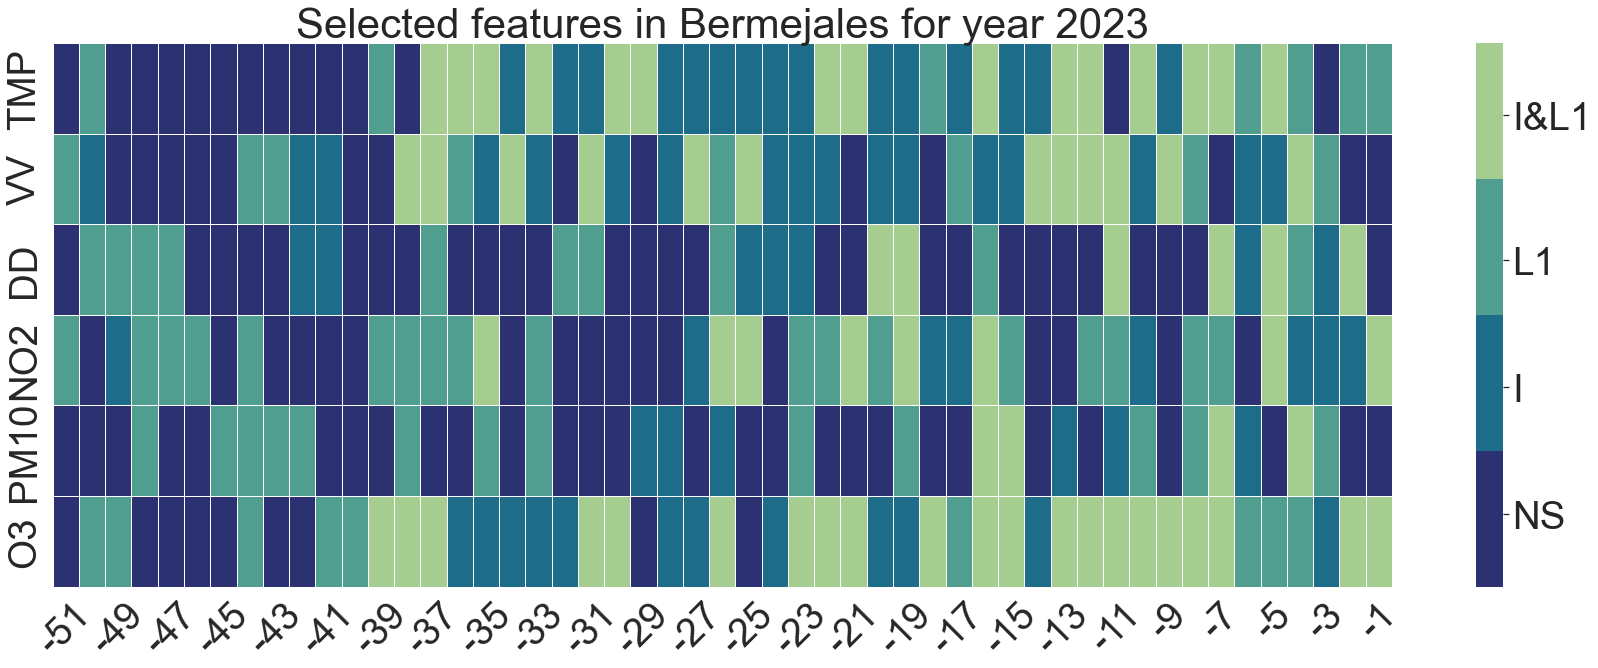

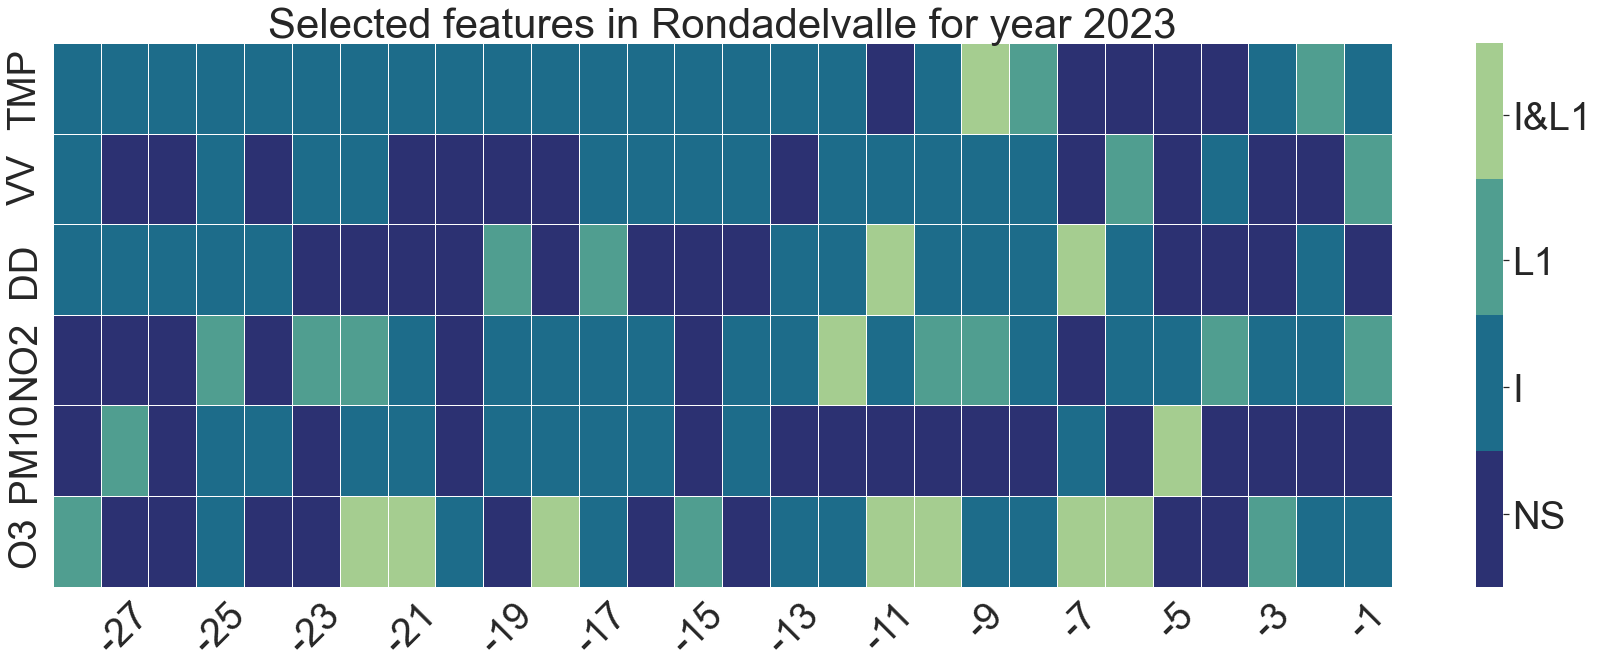

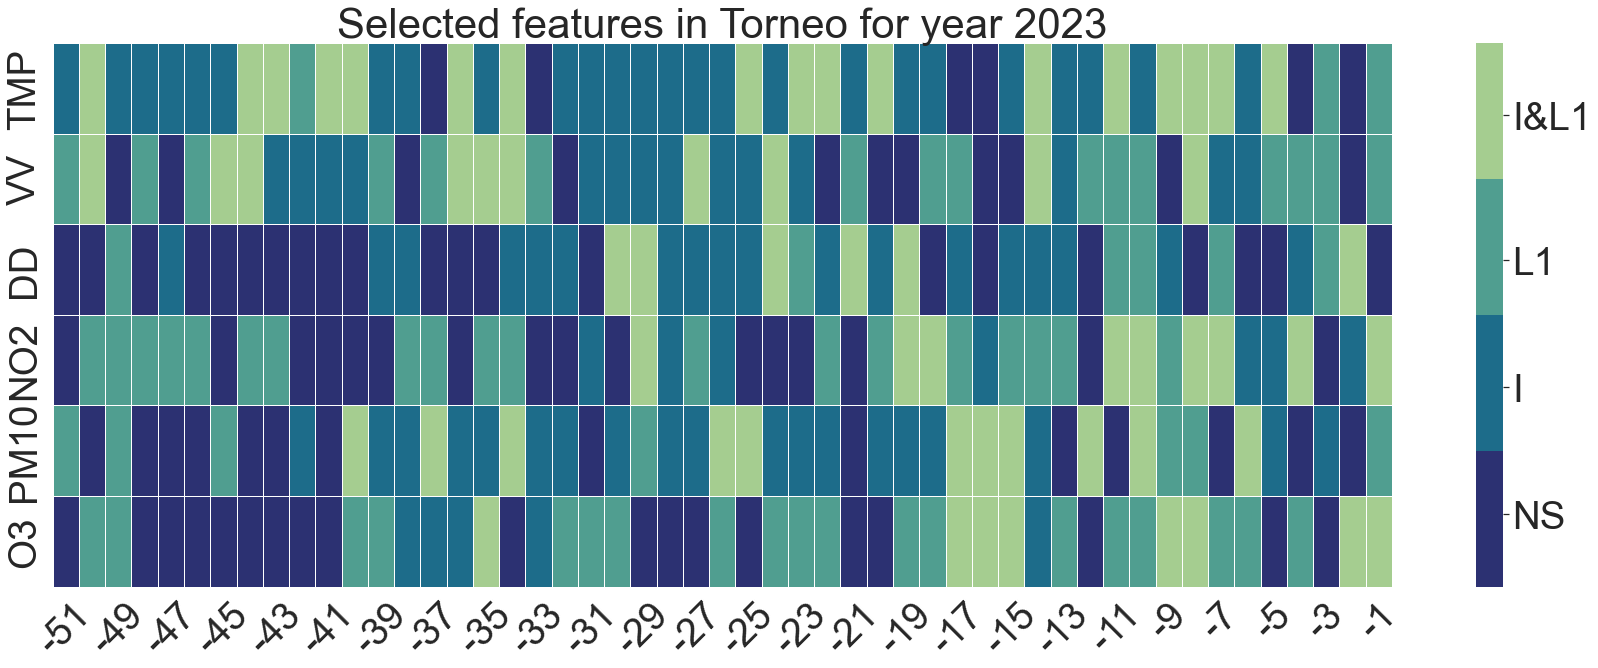

In [37]:
sns.set(font_scale=3.5)
import numpy as np
from matplotlib.colors import ListedColormap

model_name = 'LSTM*'

df_mask = pd.DataFrame()

features_list = ['tmp', 'vv', 'dd', 'no2', 'pm10', 'target_o3']#['tmp', 'vv', 'dd', 'no2', 'pm10', 'o3']
for dataset in best_results.dataset.unique():
    results_tsl_dataset = best_results[(best_results.dataset==dataset) & (best_results.model_name==model_name)].sort_values('dataset_params_test_year')
    results_tsl_dataset_2023 = results_tsl_dataset.loc[best_results['dataset_params_test_year']==2023]
    selected_features = results_tsl_dataset_2023.selected_features.apply(eval).iloc[0]

    selection_masks = []

    seq_lens = []
    for level, mask in selected_features.items():
        seq_lens.extend([int(name.split('t-')[1]) for name in mask])
    maximum_seq_len = max(seq_lens)

    level_score = [0, 1, 3, 5]
    
    for feat in features_list:
        
        mask_by_level = np.zeros((maximum_seq_len,))
        for i, (level, mask) in enumerate(selected_features.items()):
            
            mask = np.array(mask)
            feats = np.array([f'{feat} t-{t}'for t in range (maximum_seq_len, 0, -1)])

            sfeats = mask[np.core.defchararray.find(mask, feat)!=-1]

            mask_selected = np.isin(feats, sfeats).astype(np.uint)
            mask_selected[mask_selected>0] += level_score[i]
            mask_by_level += mask_selected

        selection_masks.append(mask_by_level)
    
    selection_masks = np.stack(selection_masks)
    fig, ax = plt.subplots(figsize=(30,10))

    dataset.replace("Rondadelvalle", "Ronda del valle")
    ax.set_title(f'Selected features in {dataset[:-4]} for year 2023')

    number_of_levels = int(np.max(selection_masks))

    cmap_crest = sns.cm.crest_r
    cmap = ListedColormap(cmap_crest.colors[::(len(cmap_crest.colors)-1)//(number_of_levels)])

    
    feats[-2::-2] = ''
    xticks = list(map(lambda f: f.replace('target_o3 t', ''), feats.tolist()))
    g = sns.heatmap(selection_masks, yticklabels=list(map(lambda x: x.upper(), ['tmp', 'vv', 'dd', 'no2', 'pm10', 'o3'])),cmap=cmap, xticklabels=xticks, linewidth=.5, ax=ax)
    plt.xticks(rotation=45)

    colorbar = g.collections[0].colorbar

    if 8>=number_of_levels>4:
        positions = np.array([0.4, 1.3, 2.2, 3.1, 4, 4.8, 5.7, 6.6, 7.5])
    elif number_of_levels>8:
        positions = np.array([0.4, 1.3, 2.2, 3.1, 4.2, 5, 5.9, 7, 7.8, 8.8, 9.7, 10.7, 11.5, 12.5])
    else:
        positions = np.array([0.4, 1.1, 1.8, 2.6, 3.2, 3.9, 4.6, 5.1, 5.8])

    levels = np.array(['NS', 'I', 'L1', "I&L1", "L2", "I&L2", "L1&L2", "I&L1&L2", "L3", "I&L3", "L1&L3", "L2&L3", "I&L1&L3", "I&L1&L2&L3"])
    #colorbar.set_ticks(positions[:number_of_levels+1])
    colorbar.set_ticks(positions[:number_of_levels+1])
    colorbar.set_ticklabels(levels[:number_of_levels+1])

    fig = g.get_figure()

    fig.savefig(f"figures/SelectionMasks/Ozone_{dataset}.png", bbox_inches='tight') 

    df_mask = pd.concat((df_mask, get_mask_df(selection_masks, features_list, maximum_seq_len, dataset, levels)))
    

In [12]:
df_mask["dataset"] = df_mask["dataset"].str[:-4]
df_mask

,layer_level,features,lags,dataset,layer
0,3.0,tmp,t-51,Aljarafe,I&L1
1,0.0,tmp,t-50,Aljarafe,NS
2,0.0,tmp,t-49,Aljarafe,NS
3,0.0,tmp,t-48,Aljarafe,NS
4,0.0,tmp,t-47,Aljarafe,NS
...,...,...,...,...,...
301,0.0,target_o3,t-5,Torneo,NS
302,2.0,target_o3,t-4,Torneo,L1
303,0.0,target_o3,t-3,Torneo,NS
304,3.0,target_o3,t-2,Torneo,I&L1


<Figure size 1440x1440 with 0 Axes>

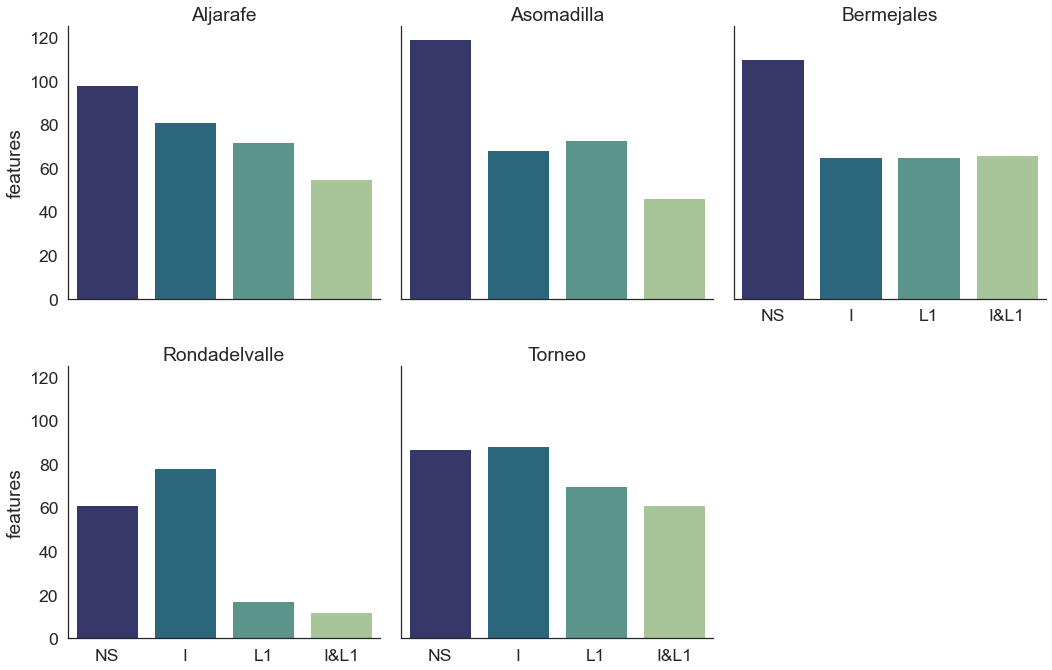

In [13]:
sns.set(font_scale=1.6, style='white')
plt.figure(figsize=(20,20))
import matplotlib


g = sns.catplot(data=df_mask.groupby(["dataset", "layer"]).count().reset_index(), kind='bar', x='layer', y="features", col='dataset', order=levels[:number_of_levels+1], palette=[matplotlib.colors.rgb2hex(c)for c in cmap.colors], col_wrap=3)#.set_yscale("log")
g.set(xlabel=None)
g.set_titles(template="{col_name}")
plt.savefig('figures/barplot_features.png')
plt.show()
plt.show()

<Figure size 1440x1440 with 0 Axes>

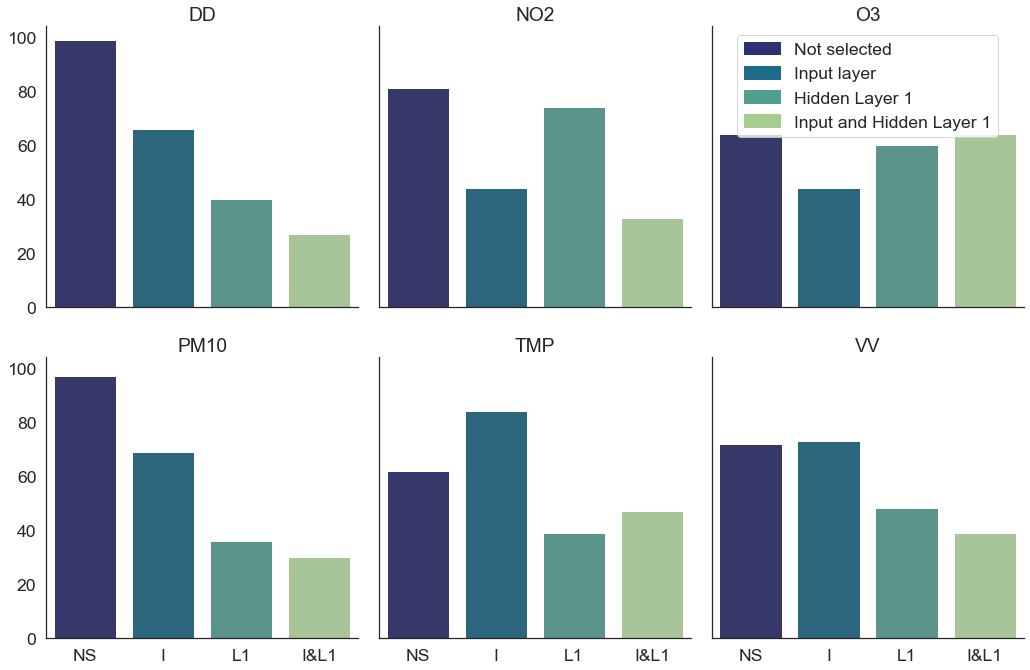

In [36]:
sns.set(font_scale=1.6, style='white')
plt.figure(figsize=(20,20))
import matplotlib
import matplotlib.patches as mpatches
patch_ns = mpatches.Patch(color=cmap.colors[0], label='Not selected')
patch_i = mpatches.Patch(color=cmap.colors[1], label='Input layer')
patch_l1 = mpatches.Patch(color=cmap.colors[2], label='Hidden Layer 1')
patch_i_l1 = mpatches.Patch(color=cmap.colors[3], label='Input and Hidden Layer 1')

handles = [patch_ns, patch_i, patch_l1, patch_i_l1]

df_mask["features"] = df_mask["features"].str.upper().str.replace("TARGET_", '')

g = sns.catplot(data=df_mask.groupby(["layer", "features"]).count().reset_index(), kind='bar', x='layer', y="dataset", col='features', order=levels[:number_of_levels+1], palette=[matplotlib.colors.rgb2hex(c)for c in cmap.colors], col_wrap=3)#.set_yscale("log")
g.set(xlabel=None, ylabel=None)
g.set_titles(template="{col_name}")

g.axes[2].legend(handles=handles, loc='upper center')


plt.savefig('figures/barplot_features_by_layer.png')
plt.show()
plt.show()

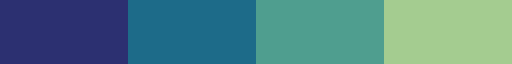

In [18]:
cmap

## Bayesian tests

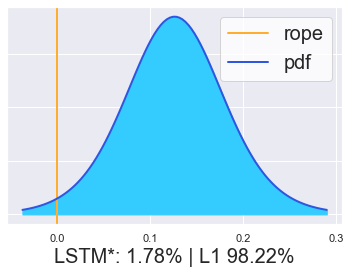

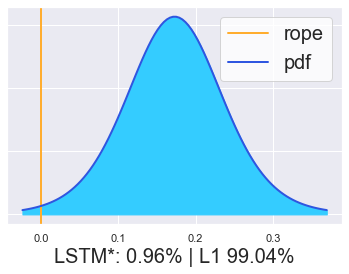

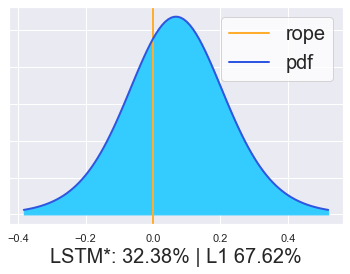

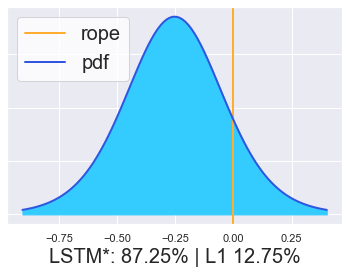

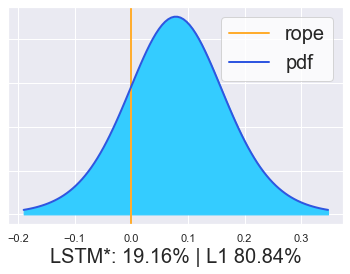

In [52]:
from baycomp import two_on_single
import matplotlib

import matplotlib.pyplot as plt



for dataset in best_results.dataset.unique():
    metrics_tsl = best_results[(best_results.dataset==dataset) & (best_results.model_name=='LSTM*')].rmse.values
    metrics_l1 = best_results[(best_results.dataset==dataset) & (best_results.model_name=='L1')].rmse.values
    probs, fig = two_on_single(metrics_tsl, metrics_l1, names=['LSTM*', 'L1'], plot=True)
    plt.xlabel(f'LSTM*: {round(probs[0]*100, 2)}% | L1 {round(probs[1]*100, 2)}%', fontsize=20)
    plt.legend(fontsize=20)
    fig.savefig(f"figures/Baytest/Baytest{dataset}.png", bbox_inches='tight') 

    

## Best hyperparameters

In [ ]:
best_hyperparameters = best_results.groupby(["dataset", "model_name"]).head(1).reset_index().copy()

In [ ]:
import numpy as np
pd.set_option('display.max_colwidth', 2000)
params = list(map(lambda my_dict: {k: round(my_dict[k], 4) if not my_dict[k].is_integer() else int(my_dict[k]) for k in my_dict if not np.isnan(my_dict[k])},best_hyperparameters.loc[:, ['model_params_layers', 'model_params_units', 'model_params_batch_size', 'model_params_lr','model_params_dropout',  'model_params_max_depth', 'model_params_alpha','selection_params_regularization']].to_dict('records')))
best_hyperparameters['window'] = best_hyperparameters.dataset_params_seq_len #
best_hyperparameters['params'] = params

best_hyperparameters[["dataset", "model_name", "window", "params", "dataset_params_seq_len"]].set_index(['dataset', 'model_name', 'window']).to_latex('tab.tex')

In [ ]:
best_hyperparameters.to_csv("results/ResSelNet/params/best_params.csv")